<a href="https://colab.research.google.com/github/gauravsethia08/3D_Reconstruction/blob/main/pointcloud_conv2d_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Installing and Importing Libraries

In [ ]:
!pip install open3d

     |████████████████████████████████| 188.4MB 80kB/s 


In [ ]:
import os
import sys
import glob
import numpy as np
import open3d as o3d
import tensorflow as tf
from matplotlib import pyplot as plt
from tensorflow.python.framework import ops
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

### Mounting Drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Parsing Dataset

In [ ]:
apple = o3d.io.read_point_cloud('/content/apple_ds.ply')
apple_points = np.asarray(apple.points)
apple_colors = np.asarray(apple.colors)
apple_mesh_points = np.concatenate((apple_points, apple_colors), axis = 1)

banana = o3d.io.read_point_cloud('/content/banana_ds.ply')
banana_points = np.asarray(banana.points)
banana_colors = np.asarray(banana.colors)
banana_mesh_points = np.concatenate((banana_points, banana_colors), axis = 1)

In [ ]:
DATA_DIR = '/content/gdrive/MyDrive/PCD_downsampled'

In [ ]:
def parse_dataset():

    points = []
    labels = []
    named_label = []
    points_label = []

    for sub_dir in os.listdir(DATA_DIR):
      label = sub_dir
      #if label == 'Apple':
      for pcd_file in os.listdir(os.path.join(DATA_DIR, sub_dir)):
        pcd_path = os.path.join(DATA_DIR, sub_dir, pcd_file)
        pcd = o3d.io.read_point_cloud(pcd_path)
        pcd_points = np.asarray(pcd.points)
        pcd_colors = np.asarray(pcd.colors)
        mesh_points = np.concatenate((pcd_points, pcd_colors), axis = 1)
        points.append(mesh_points)
        if label == 'Apple':
          labels.append([0, apple_mesh_points])
          named_label.append(0)
          points_label.append(apple_mesh_points)
        else:
          labels.append([1, banana_mesh_points])
          named_label.append(1)
          points_label.append(banana_mesh_points)
      #else:
      #  continue
    
    return points, labels, named_label, points_label
    #return np.asarray(points), np.asarray(labels)

In [ ]:
points, label, named_label, points_label= parse_dataset()

Streaming output truncated to the last 5000 lines.
Apple
Apple
Apple
Apple
Apple
Apple
Apple
Apple
Apple
Apple
Apple
Apple
Apple
Apple
Apple
Apple
Apple
Apple
Apple
Apple
Apple
Apple
Apple
Apple
Apple
Apple
Apple
Apple
Apple
Apple
Apple
Apple
Apple
Apple
Apple
Apple
Apple
Apple
Apple
Apple
Apple
Apple
Apple
Apple
Apple
Apple
Apple
Apple
Apple
Apple
Apple
Apple
Apple
Apple
Apple
Apple
Apple
Apple
Apple
Apple
Apple
Apple
Apple
Apple
Apple
Apple
Apple
Apple
Apple
Apple
Apple
Apple
Apple
Apple
Apple
Apple
Apple
Apple
Apple
Apple
Apple
Apple
Apple
Apple
Apple
Apple
Apple
Apple
Apple
Apple
Apple
Apple
Apple
Apple
Apple
Apple
Apple
Apple
Apple
Apple
Apple
Apple
Apple
Apple
Apple
Apple
Apple
Apple
Apple
Apple
Apple
Apple
Apple
Apple
Apple
Apple
Apple
Apple
Apple
Apple
Apple
Apple
Apple
Apple
Apple
Apple
Apple
Apple
Apple
Apple
Apple
Apple
Apple
Apple
Apple
Apple
Apple
Apple
Apple
Apple
Apple
Apple
Apple
Apple
Apple
Apple
Apple
Apple
Apple
Apple
Apple
Apple
Apple
Apple
Apple
Apple
Apple
Apple
A

In [ ]:
len(named_label)

5952

In [ ]:
label = np.asarray(label)

In [ ]:
#print(points.shape)
print(label.shape)

(5952, 2)


In [ ]:

#tf.keras.backend.clear_session()

## Train Test Split

In [ ]:
train_points, test_points, train_labels, test_labels, train_output, test_output = train_test_split(points, named_label, points_label, test_size=0.1, random_state=0)

In [ ]:
print(len(train_labels))

5356


## Defining Parameters

In [ ]:
BATCH_SIZE = 32
NUM_POINTS = 2048
NUM_CLASSES = 2

## Augumentation

In [ ]:
def augment(points, label):
    # jitter points
    points += tf.random.uniform(points.shape, -0.005, 0.005, dtype=tf.float64)
    # shuffle points
    points = tf.random.shuffle(points)
    return points, label

In [ ]:
yy1 = np.asarray(train_labels)
yy1 = yy1[:,0]
print(yy1.shape)
yy1 = yy1.tolist()

yy2 = np.asarray(train_labels)
yy2 = yy2[:,1]
yy2 = yy2.tolist()

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


IndexError: ignored

In [ ]:
yy_valid_1 = np.asarray(test_labels)
yy_valid_1 = yy_valid_1[:,0]
yy_valid_1 = yy_valid_1.tolist()

yy_valid_2 = np.asarray(test_labels)
yy_valid_2 = yy_valid_2[:,1]
yy_valid_2 = yy_valid_2.tolist()

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [ ]:
tf.config.run_functions_eagerly(True)

In [ ]:
train_dataset = tf.data.Dataset.from_tensors((train_points, {'decoder_o/p':train_output, 'classifier_o/p': train_labels}))#{'output1': yy1, 'output2': yy2}))
test_dataset = tf.data.Dataset.from_tensor_slices((test_points, {'decoder_o/p':test_output, 'classifier_o/p': test_labels}))

train_dataset = train_dataset.shuffle(len(train_points)).map(augment).batch(BATCH_SIZE)
test_dataset = test_dataset.shuffle(len(test_points)).map(augment).batch(BATCH_SIZE)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3504: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


In [ ]:
test_dataset

<BatchDataset shapes: ((None, 2048, 6), {decoder_o/p: (None, 2048, 6), classifier_o/p: (None,)}), types: (tf.float64, {decoder_o/p: tf.float64, classifier_o/p: tf.int32})>

## Building the model

In [ ]:
class OrthogonalRegularizer(tf.keras.regularizers.Regularizer):
    def __init__(self, num_features, l2reg=0.001):
        self.num_features = num_features
        self.l2reg = l2reg
        self.eye = tf.eye(num_features)

    def __call__(self, x):
        x = tf.reshape(x, (-1, self.num_features, self.num_features))
        xxt = tf.tensordot(x, x, axes=(2, 2))
        xxt = tf.reshape(xxt, (-1, self.num_features, self.num_features))
        return tf.reduce_sum(self.l2reg * tf.square(xxt - self.eye))

In [ ]:
inputs = tf.keras.Input(shape=(NUM_POINTS, 6))

#Enocder
x = tf.keras.layers.Reshape((128,16,6))(inputs)
x = tf.keras.layers.Conv2D(32, (1,1))(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D()(x)
x = tf.keras.layers.Conv2D(64, (1,1))(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Conv2D(128, (1,1))(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)

#Decoder
d = tf.keras.layers.Dense(768, activation="softmax")(x)
d = tf.keras.layers.Reshape((32,4, 6))(d)
d = tf.keras.layers.Conv2DTranspose(64,(3, 3), strides=2, activation='relu', padding='same')(d)
d = tf.keras.layers.BatchNormalization()(d)
d = tf.keras.layers.Conv2DTranspose(32, (3, 3), strides=2, activation='relu', padding='same')(d)
d = tf.keras.layers.Conv2D(6, (1,1), activation='tanh', padding='same')(d)
output_decoder = tf.keras.layers.Reshape((NUM_POINTS,6), name='decoder_o/p')(d)

#Classifier
c = tf.keras.layers.Dense(32, activation='relu')(x)
c = tf.keras.layers.Dropout(0.3)(c)
c = tf.keras.layers.BatchNormalization()(c)
output_classifier = tf.keras.layers.Dense(1, activation='sigmoid', name='classifier_o/p')(c)

model = tf.keras.Model(inputs=inputs, outputs=[output_decoder, output_classifier], name="pointnet")
model.summary()

Model: "pointnet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 2048, 6)]    0                                            
__________________________________________________________________________________________________
reshape_6 (Reshape)             (None, 128, 16, 6)   0           input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_12 (Conv2D)              (None, 128, 16, 32)  224         reshape_6[0][0]                  
__________________________________________________________________________________________________
batch_normalization_12 (BatchNo (None, 128, 16, 32)  128         conv2d_12[0][0]                  
___________________________________________________________________________________________

In [ ]:
#early_stop = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', min_delta = 0.001, patience = 5000, mode = 'min', verbose = 1, restore_best_weights = True)
#reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 100, min_delta = 0.001, mode = 'min', verbose = 1)

In [ ]:
def nn_distance_cpu(pc1, pc2):
    '''
    Input:
        pc1: float TF tensor in shape (B,N,C) the first point cloud
        pc2: float TF tensor in shape (B,M,C) the second point cloud
    Output:
        dist1: float TF tensor in shape (B,N) distance from first to second
        idx1: int32 TF tensor in shape (B,N) nearest neighbor from first to second
        dist2: float TF tensor in shape (B,M) distance from second to first
        idx2: int32 TF tensor in shape (B,M) nearest neighbor from second to first
    '''
    N = 2048#pc1.get_shape()[1].value
    
    M = 2048#pc2.get_shape()[1].value
    
    pc1_expand_tile = tf.tile(tf.expand_dims(pc1,2), [1,1,M,1])
    
    pc2_expand_tile = tf.tile(tf.expand_dims(pc2,1), [1,N,1,1])
    
    pc_diff = pc1_expand_tile - pc2_expand_tile # B,N,M,C
    
    pc_dist = tf.reduce_sum(pc_diff ** 2, axis=-1) # B,N,M
    
    dist1 = tf.reduce_min(pc_dist, axis=2) # B,N
    
    idx1 = tf.argmin(pc_dist, axis=2) # B,N
    
    dist2 = tf.reduce_min(pc_dist, axis=1) # B,M
    
    idx2 = tf.argmin(pc_dist, axis=1) # B,M
    
    return dist1, idx1, dist2, idx2

In [ ]:
def nn_loss(y_pred, y_label):
    
    #y_label = tf.Variable(y_label)
    #y_pred = tf.Variable(y_pred)
    dists_forward,_,dists_backward,_ = nn_distance_cpu(y_pred[:,:,:3], y_label[:,:,:3])
    loss = tf.reduce_mean(dists_forward+dists_backward)
    
    return loss*100

In [ ]:
def custom_loss(y_true, y_pred):
  
  y_true = tf.constant(y_true)
  y_pred = tf.constant(y_pred)

  dist_loss = tf.reduce_sum(tf.sqrt(tf.reduce_sum(tf.square(y_true[:,:,:3] - y_pred[:,:,:3]), 2)))
  #print(dist_loss)
  #print(dist_loss.shape)
  #dist_loss = tf.math.reduce_euclidean_norm([y_true[:,:3], y_pred[:,:3]])
  #print(dist_loss)
  #color_loss = tf.math.reduce_sum([y_true[:,3:], y_pred[:,3:]])
  return dist_loss #5*dist_loss + 0.5 * color_loss #10*dist_loss + color_loss

In [ ]:
model.compile(
    loss={
            'classifier_o/p': tf.keras.losses.BinaryCrossentropy(),
            'decoder_o/p': custom_loss,
             
        },
        loss_weights={
            'decoder_o/p': 5.,
            'classifier_o/p': 0.5
        },
        metrics={
            'classifier_o/p': 'accuracy'
             },
    #loss= custom_loss, #tf.keras.losses.BinaryCrossentropy(), #"sparse_categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),run_eagerly=True
    #metrics=["acc"] #tf.keras.metrics.RootMeanSquaredError() #,
)

h = model.fit(test_dataset, epochs=1000, validation_data=test_dataset)#, callbacks=[early_stop,reduce_lr])


Epoch 1/1000
19/19 [==============================] - 9s 432ms/step - loss: 6614.1955 - decoder_o/p_loss: 1322.8134 - classifier_o/p_loss: 0.2574 - classifier_o/p_accuracy: 0.9075 - val_loss: 6892.3369 - val_decoder_o/p_loss: 1378.4091 - val_classifier_o/p_loss: 0.5820 - val_classifier_o/p_accuracy: 0.8490
Epoch 2/1000
19/19 [==============================] - 8s 418ms/step - loss: 6448.6656 - decoder_o/p_loss: 1289.7096 - classifier_o/p_loss: 0.2365 - classifier_o/p_accuracy: 0.9318 - val_loss: 6886.2974 - val_decoder_o/p_loss: 1377.2039 - val_classifier_o/p_loss: 0.5538 - val_classifier_o/p_accuracy: 0.8691
Epoch 3/1000
19/19 [==============================] - 8s 410ms/step - loss: 6284.2797 - decoder_o/p_loss: 1256.8371 - classifier_o/p_loss: 0.1876 - classifier_o/p_accuracy: 0.9475 - val_loss: 6905.0254 - val_decoder_o/p_loss: 1380.9525 - val_classifier_o/p_loss: 0.5277 - val_classifier_o/p_accuracy: 0.9060
Epoch 4/1000
19/19 [==============================] - 8s 416ms/step - loss: 

## Plotting training and validation curves

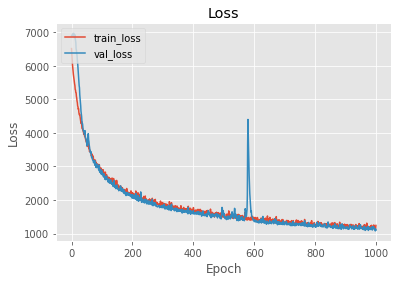

In [ ]:
plt.style.use("ggplot")
plt.figure()

plt.plot(h.history["loss"], label="train_loss")
plt.plot(h.history["val_loss"], label="val_loss")
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc="upper left")
plt.show()

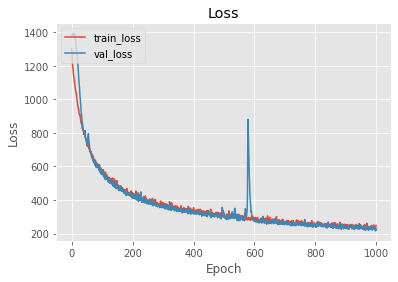

In [ ]:
plt.style.use("ggplot")
plt.figure()
plt.plot(h.history["decoder_o/p_loss"], label="train_loss")
plt.plot(h.history["val_decoder_o/p_loss"], label="val_loss")
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc="upper left")
plt.show()

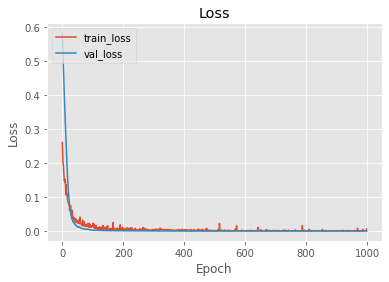

In [ ]:
plt.style.use("ggplot")
plt.figure()
plt.plot(h.history["classifier_o/p_loss"], label="train_loss")
plt.plot(h.history["val_classifier_o/p_loss"], label="val_loss")
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc="upper left")
plt.show()

## Confusion Matrix

In [ ]:
y_pred = model.predict(label)

In [ ]:
max(label[0][0])

<tf.Tensor: shape=(), dtype=float64, numpy=0.5333333333333333>

In [ ]:
y_pred.shape

(24, 2048, 6)

In [ ]:
y_pred_list = []
label_list = []
for img, label in test_dataset:
  Y_pred = model.predict(img)
  #y_pred = Y_pred.round()
  #for i, pred in enumerate(y_pred):
  #  y_pred_list.append(pred)
  #  label_list.append(label[i])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3504: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


In [ ]:
len(Y_pred)

2

In [ ]:
pcd_points = Y_pred[0][1]
pcd_points.shape

(2048, 6)

In [ ]:
Y_pred[1][1].round()

array([1.], dtype=float32)

In [ ]:
pcd_points[:,:3].shape

(2048, 3)

In [ ]:
pointclo = o3d.geometry.PointCloud()
pointclo.points = o3d.utility.Vector3dVector(pcd_points[:,:3])
pointclo.colors = o3d.utility.Vector3dVector(pcd_points[:,3:])

In [ ]:
np.max(pcd_points[:,3:])

0.12897207

In [ ]:
o3d.io.write_point_cloud('rc_output_combined_b.ply', pointclo)

[Open3D WARNING] Write Ply clamped color value to valid range


True

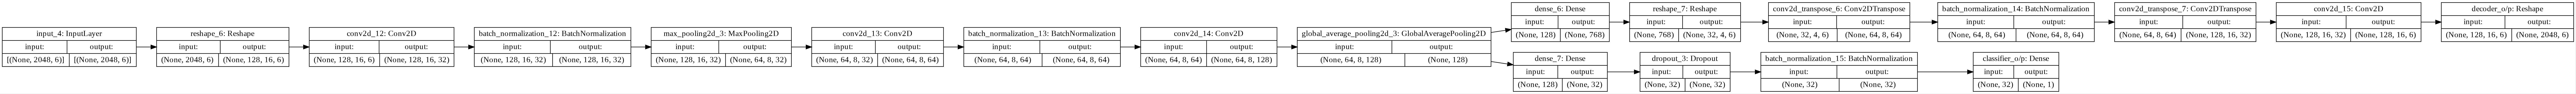

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(
    model, to_file='model.jpg' , show_shapes=True, show_layer_names=True,
    rankdir='LR', expand_nested=True, dpi=196
)

In [ ]:
model.save('reconstruction_classifier.h5')